In [119]:
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns

credit_card_data = pd.read_csv('UCI_Credit_Card.csv')

# remove the rows with negative bill amount
credit_card_data = credit_card_data[credit_card_data['BILL_AMT1'] >= 0]
credit_card_data = credit_card_data[credit_card_data['BILL_AMT2'] >= 0]
credit_card_data = credit_card_data[credit_card_data['BILL_AMT3'] >= 0]
credit_card_data = credit_card_data[credit_card_data['BILL_AMT4'] >= 0]
credit_card_data = credit_card_data[credit_card_data['BILL_AMT5'] >= 0]
credit_card_data = credit_card_data[credit_card_data['BILL_AMT6'] >= 0]

GenderMap = {2:'female', 1:'male'}
MarriageMap = {1:'married', 2:'single', 3: 'other', 0:'other2'}
EducationMap = {1:'graduate school', 2:'university', 3:'high school', 4: 'other', 5:'unkown', 6:'unkown', 0:'unkown'}

credit_card_data['SEX'] = credit_card_data['SEX'].map(GenderMap)
credit_card_data['MARRIAGE'] = credit_card_data['MARRIAGE'].map(MarriageMap)
credit_card_data['EDUCATION'] = credit_card_data['EDUCATION'].map(EducationMap)

# dummify each of the variables
credit_card_data['PAY_0'] = credit_card_data['PAY_0'].astype(str)
credit_card_data['PAY_2'] = credit_card_data['PAY_2'].astype(str)
credit_card_data['PAY_3'] = credit_card_data['PAY_3'].astype(str)
credit_card_data['PAY_4'] = credit_card_data['PAY_4'].astype(str)
credit_card_data['PAY_5'] = credit_card_data['PAY_5'].astype(str)
credit_card_data['PAY_6'] = credit_card_data['PAY_6'].astype(str)

# getting the target and predictor models
target = credit_card_data['default.payment.next.month']
predictor = credit_card_data.iloc[:,credit_card_data.columns!='default.payment.next.month']
predictor.drop('ID', axis=1, inplace=True)

# get all categorical variables and dumify them
categorical_columns = [col for col in predictor.columns.values if predictor[col].dtype=='object']

# create another data frame with only the columns that we want
df_categorical = predictor[categorical_columns]

# values that are not needed to be dummified
df_numerical = predictor.drop(categorical_columns, axis=1)

# don't need all of them, need only 1 less than all of them
dummy_code_cat_vars = pd.get_dummies(df_categorical, drop_first=True)

# combine the variables back 
df_predictor = pd.concat([df_numerical, dummy_code_cat_vars], axis=1)

# best predictor model
df_predictor_2 = df_predictor[['LIMIT_BAL','PAY_0_2','PAY_2_2','PAY_3_2','BILL_AMT1','BILL_AMT6','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']]

X_train, X_test, y_train, y_test = train_test_split(df_predictor, target, test_size = 0.3, random_state =0)

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(df_predictor_2, target, test_size = 0.3, random_state =0)

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train))
X_test_scaled = pd.DataFrame(scaler.transform(X_test))

X_train_scaled.columns = X_train.columns.values
X_test_scaled.columns = X_test.columns.values

X_train_scaled.index = X_train.index.values
X_test_scaled.index = X_test.index.values

# scalling on the second predictor model
scaler_2 = StandardScaler()
X_train_scaled_2 = pd.DataFrame(scaler_2.fit_transform(X_train_2))
X_test_scaled_2 = pd.DataFrame(scaler_2.transform(X_test_2))

X_train_scaled_2.columns = X_train_2.columns.values
X_test_scaled_2.columns = X_test_2.columns.values

X_train_scaled_2.index = X_train_2.index.values
X_test_scaled_2.index = X_test_2.index.values


<ipython-input-119-1d5e09165c8a>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictor.drop('ID', axis=1, inplace=True)


In [5]:
df_predictor_2.head()

,LIMIT_BAL,PAY_0_2,PAY_2_2,PAY_3_2,BILL_AMT1,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,20000.0,1,1,0,3913.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0
1,120000.0,0,1,0,2682.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0
2,90000.0,0,0,0,29239.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0
3,50000.0,0,0,0,46990.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0
4,50000.0,0,0,0,8617.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0


In [126]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

predicted_no_default = []
predicted_default = []
accuracy = []
auc_lst = []

classifier = RandomForestClassifier(n_estimators=100, random_state=0)
model_RF = classifier.fit(X_train_scaled, y_train)

classifier = xgb.XGBClassifier(n_estimators=100, random_state=0)
model_XGB = classifier.fit(X_train_scaled, y_train)

classifier = LogisticRegression()
model_LR = classifier.fit(X_train_scaled, y_train)

classifier = AdaBoostClassifier()
model_ADA = classifier.fit(X_train_scaled, y_train)

classifier = DecisionTreeClassifier()
model_DT = classifier.fit(X_train_scaled, y_train)

classifier = KNeighborsClassifier(n_neighbors=5)
model_KNN = classifier.fit(X_train_scaled, y_train)

classifier = SVC()
model_SVM = classifier.fit(X_train_scaled, y_train)

models = [model_RF, model_LR, model_KNN, model_DT, model_SVM, model_XGB, model_ADA]
# models_2 = [model_RF_2, model_LR_2, model_KNN_2, model_DT_2, model_SVM_2, model_XGB_2]

for model in models:
    
    y_pred = model.predict(X_test_scaled)
    cnf_matrix = confusion_matrix(y_test, y_pred)
    cf_df = pd.DataFrame(cnf_matrix, index = [i for i in ['No Default', 'Default']], columns = [i for i in ['No Default', 'Default']])
    auc = roc_auc_score(y_test, y_pred)
    
    predicted_no_default.append(cf_df['No Default'][0])
    predicted_default.append(cf_df['Default'][1])
    accuracy.append(accuracy_score(y_test, y_pred))
    auc_lst.append(auc)


/Users/vedanshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vedanshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

In [125]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

predicted_no_default_2 = []
predicted_default_2 = []
accuracy_2 = []
auc_lst_2 = []

classifier = RandomForestClassifier(n_estimators=100, random_state=0)
model_RF_2 = classifier.fit(X_train_scaled_2, y_train_2)

classifier = AdaBoostClassifier(n_estimators=100, random_state=0)
model_ADA_2 = classifier.fit(X_train_scaled_2, y_train_2)

classifier = xgb.XGBClassifier(n_estimators=100, random_state=0)
model_XGB_2 = classifier.fit(X_train_scaled_2, y_train_2)

classifier = LogisticRegression()
model_LR_2 = classifier.fit(X_train_scaled_2, y_train_2)

classifier = DecisionTreeClassifier()
model_DT_2 = classifier.fit(X_train_scaled_2, y_train_2)

classifier = KNeighborsClassifier(n_neighbors=5)
model_KNN_2 = classifier.fit(X_train_scaled_2, y_train_2)

classifier = SVC()
model_SVM_2 = classifier.fit(X_train_scaled_2, y_train_2)

models_2 = [model_RF_2, model_LR_2, model_KNN_2, model_DT_2, model_SVM_2, model_XGB_2, model_ADA_2]

for model in models_2:

    y_pred_2 = model.predict(X_test_scaled_2)
    cnf_matrix_2 = confusion_matrix(y_test_2, y_pred_2)
    cf_df_2 = pd.DataFrame(cnf_matrix_2, index = [i for i in ['No Default', 'Default']], columns = [i for i in ['No Default', 'Default']])
    auc_2 = roc_auc_score(y_test_2, y_pred_2)
    
    predicted_no_default_2.append(cf_df_2['No Default'][0])
    predicted_default_2.append(cf_df_2['Default'][1])
    accuracy_2.append(accuracy_score(y_test_2, y_pred_2))
    auc_lst_2.append(auc_2)
    

/Users/vedanshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [124]:
predicted_no_default_2

[6099, 6228, 5971, 5332, 6129, 6085]

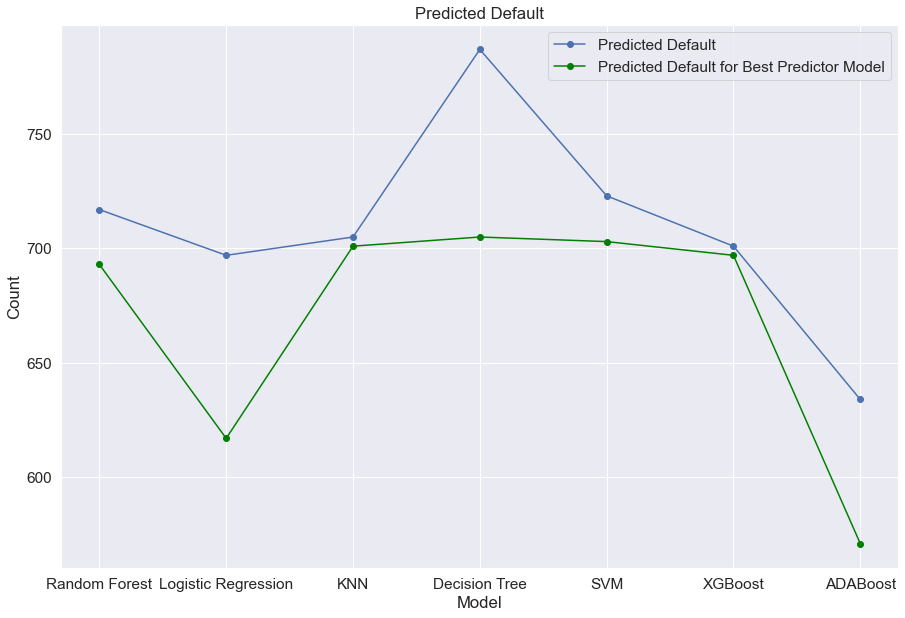

In [127]:
# plot the predicted_no_default, predicted_default, accuracy, auc_lst
plt.figure(figsize=(15,10))
plt.plot(['Random Forest', 'Logistic Regression', 'KNN', 'Decision Tree', 'SVM', 'XGBoost', 'ADABoost'], predicted_default, marker='o', label='Predicted Default')
plt.plot(['Random Forest', 'Logistic Regression', 'KNN', 'Decision Tree', 'SVM', 'XGBoost', 'ADABoost'], predicted_default_2, marker='o', label='Predicted Default for Best Predictor Model', color='green')
plt.title('Predicted Default')
plt.legend()
plt.xlabel('Model')
plt.ylabel('Count')
plt.legend()
plt.show()

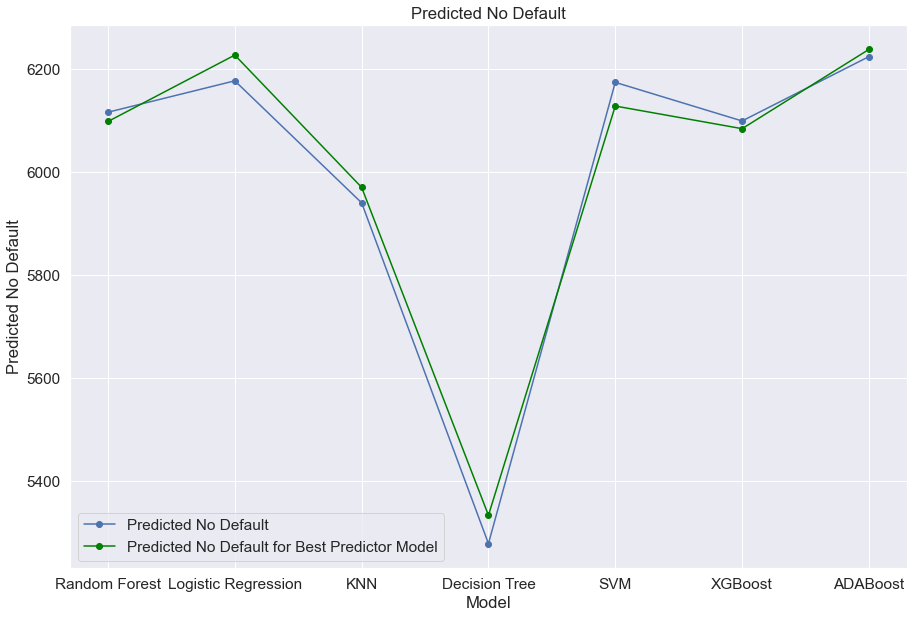

In [129]:
# plot the predicted_no_default, predicted_default, accuracy, auc_lst
plt.figure(figsize=(15,10))
plt.plot(['Random Forest', 'Logistic Regression', 'KNN', 'Decision Tree', 'SVM', 'XGBoost', 'ADABoost'], predicted_no_default, marker='o', label='Predicted No Default')
plt.plot(['Random Forest', 'Logistic Regression', 'KNN', 'Decision Tree', 'SVM', 'XGBoost', 'ADABoost'], predicted_no_default_2, marker='o', label='Predicted No Default for Best Predictor Model', color='green')
plt.title('Predicted No Default')
plt.xlabel('Model')
plt.ylabel('Predicted No Default')
plt.legend()
plt.show()

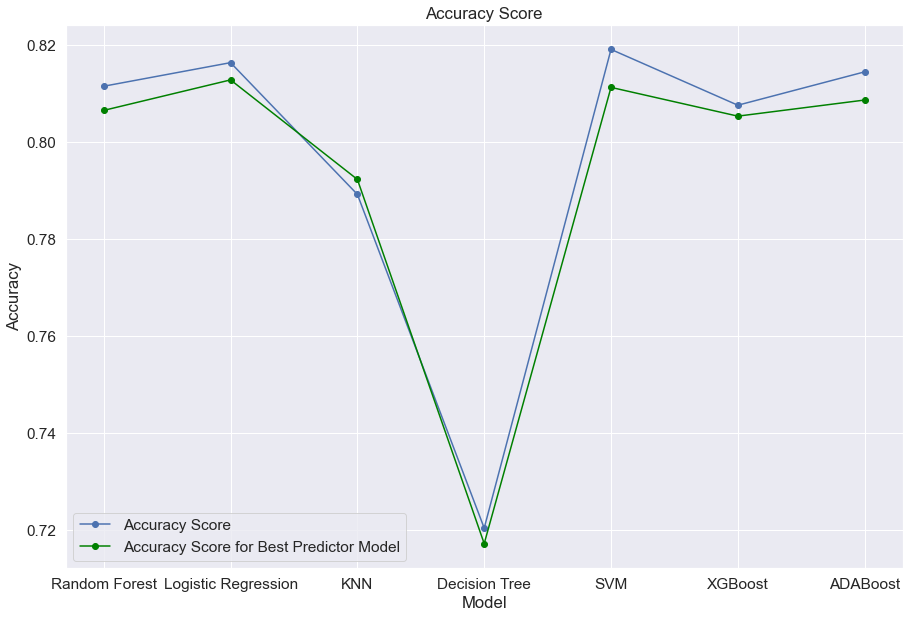

In [130]:
# plot the predicted_no_default, predicted_default, accuracy, auc_lst
plt.figure(figsize=(15,10))
plt.plot(['Random Forest', 'Logistic Regression', 'KNN', 'Decision Tree', 'SVM', 'XGBoost', 'ADABoost'], accuracy, marker='o', label='Accuracy Score')
plt.plot(['Random Forest', 'Logistic Regression', 'KNN', 'Decision Tree', 'SVM', 'XGBoost', 'ADABoost'], accuracy_2, marker='o', label='Accuracy Score for Best Predictor Model', color='green')
plt.title('Accuracy Score')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

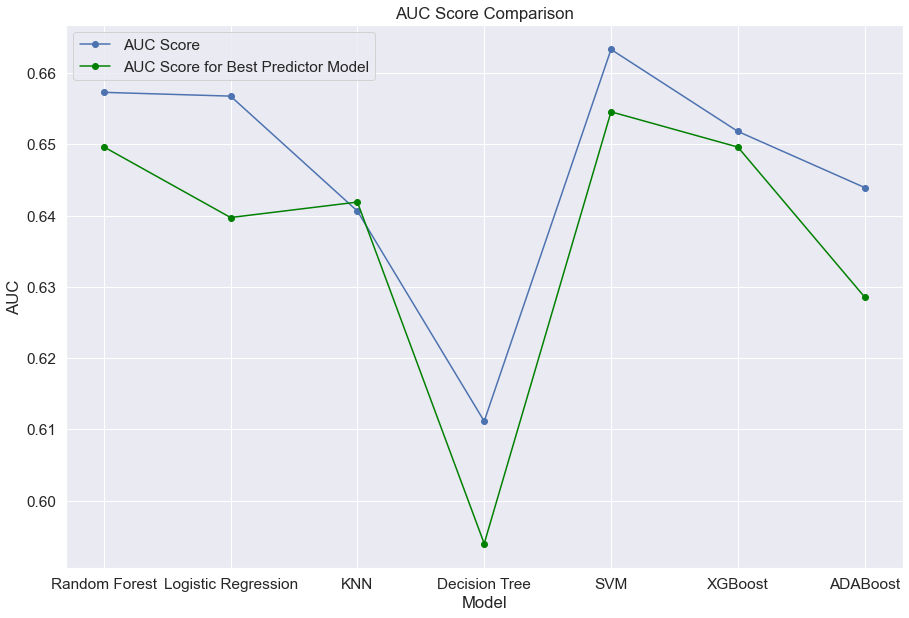

In [131]:
# plot the predicted_no_default, predicted_default, accuracy, auc_lst
plt.figure(figsize=(15,10))
plt.plot(['Random Forest', 'Logistic Regression', 'KNN', 'Decision Tree', 'SVM', 'XGBoost', 'ADABoost'], auc_lst, marker = 'o', label='AUC Score')
plt.plot(['Random Forest', 'Logistic Regression', 'KNN', 'Decision Tree', 'SVM', 'XGBoost', 'ADABoost'], auc_lst_2, marker = 'o', label='AUC Score for Best Predictor Model', color='green')
plt.title('AUC Score Comparison')
plt.xlabel('Model')
plt.ylabel('AUC')
plt.legend()
plt.show()

In [134]:
# performing k-fold cross validation
from sklearn.model_selection import cross_val_score

# accuracies = cross_val_score(estimator = model_RF, X = X_train_scaled, y = y_train, cv = 10)
# print('Random Forest Accuracy: {:.2f} %'.format(accuracies.mean()*100))
# print('Random Forest Standard Deviation: {:.2f} %'.format(accuracies.std()*100))

print()

mean_lst = []
accuracy_lst = []
df = pd.DataFrame(columns=['model', 'mean', 'accuracy'])
models=[model_RF, model_LR, model_KNN, model_DT, model_SVM, model_XGB, model_ADA, model_RF_2, model_LR_2, model_KNN_2, model_DT_2, model_SVM_2, model_XGB_2, model_ADA_2]
for model in models:
    accuracies = cross_val_score(estimator = model, X = X_train_scaled, y = y_train, cv = 10)
    mean = accuracies.mean()*100
    mean_lst.append(mean)
    
    accuracy = accuracies.std()*100
    accuracy_lst.append(accuracy)
    
# # convert model to string of the model name
# df['model'].append(['model_RF', 'model_LR', 'model_KNN', 'model_DT', 'model_SVM', 'model_XGB', 'model_RF_2', 'model_LR_2', 'model_KNN_2', 'model_DT_2', 'model_SVM_2', 'model_XGB_2'])
# df['mean'].append(mean_lst)
# df['accuracy'].append(accuracy_lst)

# add values to the dataframe
df['model'] = ['model_RF', 'model_LR', 'model_KNN', 'model_DT', 'model_SVM', 'model_XGB', 'model_ADA', 'model_RF_2', 'model_LR_2', 'model_KNN_2', 'model_DT_2', 'model_SVM_2', 'model_XGB_2', 'model_ADA_2']
df['mean'] = mean_lst
df['accuracy'] = accuracy_lst

/Users/vedanshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vedanshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

ValueError: Length of values (14) does not match length of index (13)

In [143]:
df_2 = pd.DataFrame(columns=['model', 'mean', 'accuracy'])
df_2['model'] = ['model_RF', 'model_LR', 'model_KNN', 'model_DT', 'model_SVM', 'model_XGB', 'model_ADA', 'model_RF_2', 'model_LR_2', 'model_KNN_2', 'model_DT_2', 'model_SVM_2', 'model_XGB_2', 'model_ADA_2']
df_2['mean'] = mean_lst
df_2['accuracy'] = accuracy_lst

In [139]:
len(['model_RF', 'model_LR', 'model_KNN', 'model_DT', 'model_SVM', 'model_XGB', 'model_ADA', 'model_RF_2', 'model_LR_2', 'model_KNN_2', 'model_DT_2', 'model_SVM_2', 'model_XGB_2', 'model_ADA_2'])

14

In [140]:
len(mean_lst)

14

In [141]:
len(accuracy_lst)

14

In [136]:
# add values to the dataframe
df['model'] = ['model_RF', 'model_LR', 'model_KNN', 'model_DT', 'model_SVM', 'model_XGB', 'model_ADA' 'model_RF_2', 'model_LR_2', 'model_KNN_2', 'model_DT_2', 'model_SVM_2', 'model_XGB_2', 'model_ADA_2']
df['mean'] = mean_lst
df['accuracy'] = accuracy_lst

ValueError: Length of values (14) does not match length of index (13)

In [144]:
predicted_default_c = predicted_default + predicted_default_2
predicted_no_default_c = predicted_no_default + predicted_no_default_2
accuracy_c = accuracy + accuracy_2
auc_lst_c = auc_lst + auc_lst_2

ValueError: Length of values (7) does not match length of index (14)

In [147]:
df_2['predicted_default'] = predicted_default_c
df_2['predicted_no_default'] = predicted_no_default_c
df_2['accuracy'] = accuracy_c
df_2['auc_lst'] = auc_lst_c

ValueError: Length of values (7) does not match length of index (14)

In [146]:
len(predicted_default_c)

14

In [148]:
df_2

,model,mean,accuracy,predicted_default,predicted_no_default
0,model_RF,81.719185,0.696988,717,6117
1,model_LR,82.075406,0.422764,697,6178
2,model_KNN,79.785202,0.740301,705,5941
3,model_DT,72.675484,0.939838,787,5279
4,model_SVM,81.963446,0.369828,723,6175
5,model_XGB,81.011756,0.614259,701,6100
6,model_ADA,81.744601,0.407275,634,6225
7,model_RF_2,81.719185,0.696988,693,6099
8,model_LR_2,82.075406,0.422764,617,6228
9,model_KNN_2,79.785202,0.740301,701,5971


In [117]:
accuracies = cross_val_score(estimator = model_ADA_2, X = X_train_scaled_2, y = y_train_2, cv = 10)
mean_lst.append(accuracies.mean()*100)
accuracy_lst.append(accuracies.std()*100)

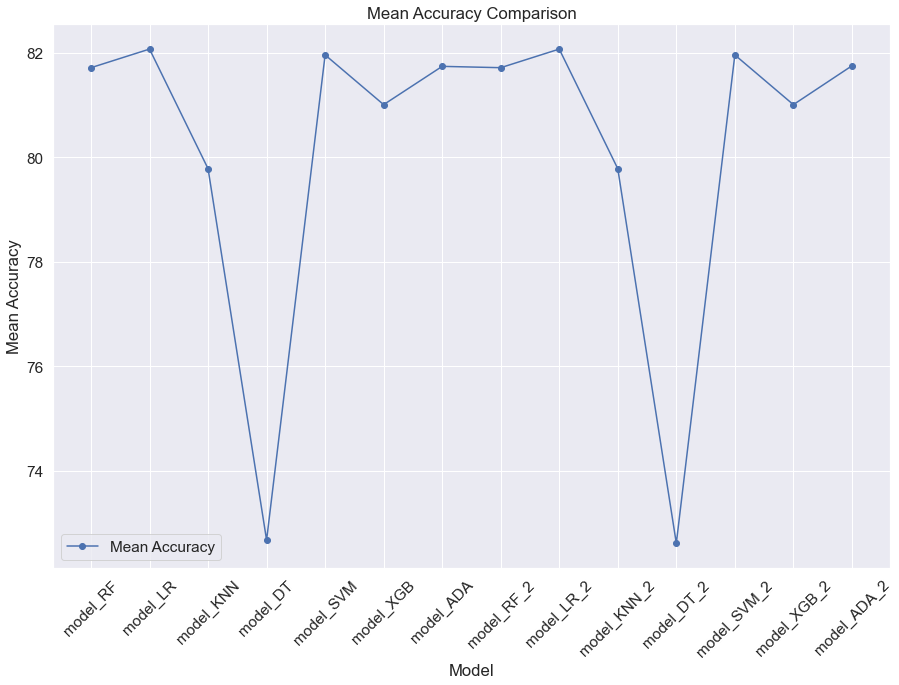

In [151]:
plt.figure(figsize=(15,10))
plt.plot(df_2['model'], df_2['mean'], marker='o', label='Mean Accuracy')
plt.xticks(rotation=45)
plt.xlabel('Model')
plt.ylabel('Mean Accuracy')
plt.title('Mean Accuracy Comparison')
plt.legend()
plt.show()

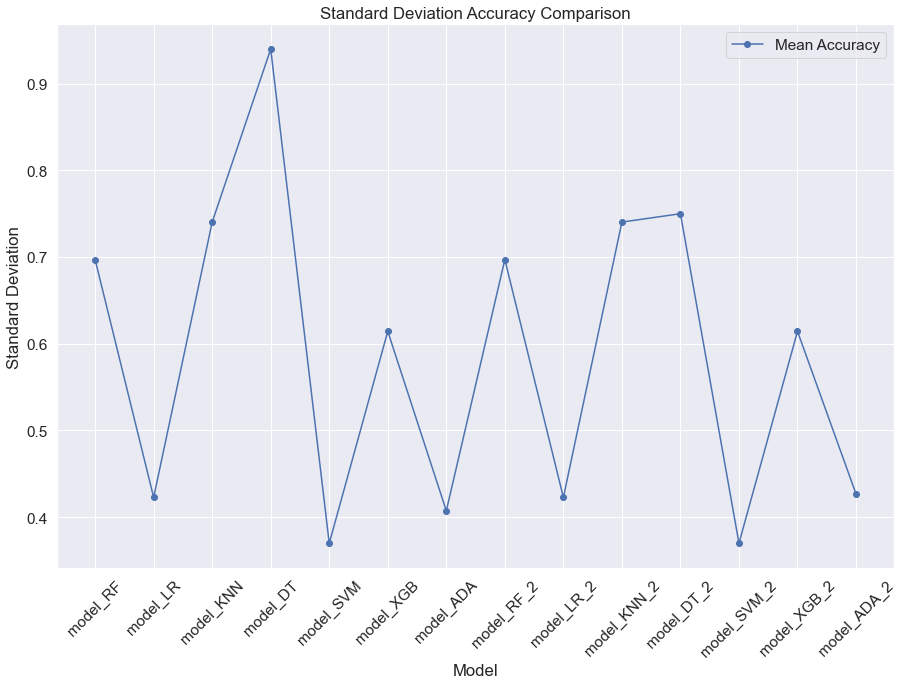

In [153]:
plt.figure(figsize=(15,10))
plt.plot(df_2['model'], df_2['accuracy'], marker='o', label='Mean Accuracy')
plt.xticks(rotation=45)
plt.xlabel('Model')
plt.ylabel('Standard Deviation')
plt.title('Standard Deviation Accuracy Comparison')
plt.legend()
plt.show()

In [101]:

def confusion_mat(y_test, y_pred):
    cnf_matrix = confusion_matrix(y_test, y_pred)
    # data['cnf_mat'] = cnf_matrix

    # make confusion matrix look better
    cf_df = pd.DataFrame(cnf_matrix, index = [i for i in ['No Default', 'Default']], columns = [i for i in ['No Default', 'Default']])
    sns.set(font_scale=1.4)
    plt.figure(figsize=(10,10))
    sns.heatmap(cf_df, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    
def create_roc_curve(y_test, y_pred):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    # data['auc'] = auc
    plt.plot(fpr, tpr, label='AUC = %0.2f' % auc)
    # plot accuracy score
    # plt.plot(fpr, tpr, label='Accuracy = %0.2f' % accuracy_score)
    # print(accuracy_score)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

def main(y_test, model):
    y_pred = model.predict(X_test_scaled_2)
    
    # builds a classification report
    clf = classification_report(y_test, y_pred)
    # data['clf'] = clf
    print(clf)
    
    accuracy = accuracy_score(y_test, y_pred)
    print(accuracy)
    
    # builds the confusion matrix
    confusion_mat(y_test, y_pred)
    
    y_pred_proba = model.predict_proba(X_test_scaled_2)[:,1]
    
    # creating the roc cuurve with the roc_auc_score
    create_roc_curve(y_test, y_pred_proba)

# classifier = RandomForestClassifier(n_estimators=100, random_state=0)
# model_RF = classifier.fit(X_train_scaled, y_train)
# main(y_test, model_RF)

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      6505
           1       0.69      0.38      0.49      1916

    accuracy                           0.82      8421
   macro avg       0.76      0.66      0.69      8421
weighted avg       0.80      0.82      0.80      8421

0.8191426196413728


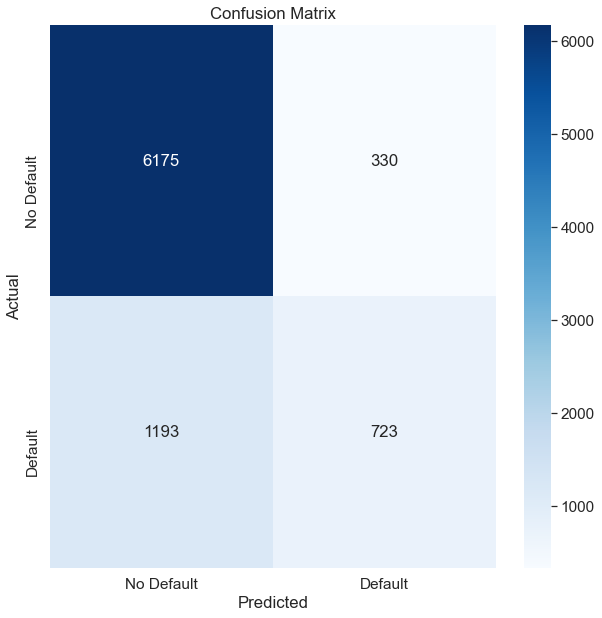

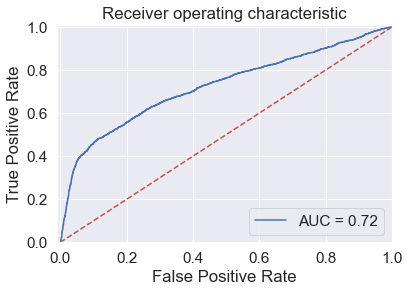

In [111]:
classifier = SVC(probability=True, random_state=0)
model_DT_2 = classifier.fit(X_train_scaled_2, y_train_2)
main(y_test_2, model_DT_2)

In [65]:
# classifier = LinearRegression(n_estimators=100, random_state=0)
# classifier = RandomForestClassifier(n_estimators=100, random_state=0)
# model_RF_2 = classifier.fit(X_train_scaled_2, y_train_2)

# classifier = xgb.XGBClassifier(n_estimators=100, random_state=0)
# model_XGB_2 = classifier.fit(X_train_scaled_2, y_train_2)

# classifier = LogisticRegression()
# model_LR_2 = classifier.fit(X_train_scaled_2, y_train_2)

# classifier = DecisionTreeClassifier()
# model_DT_2 = classifier.fit(X_train_scaled_2, y_train_2)

# classifier = KNeighborsClassifier(n_neighbors=5)
# model_KNN_2 = classifier.fit(X_train_scaled_2, y_train_2)

# classifier = SVC()
# model_SVM_2 = classifier.fit(X_train_scaled_2, y_train_2)

# models = [model_RF, model_LR, model_KNN, model_DT, model_SVM, model_XGB]
models = [model_RF_2, model_LR_2, model_KNN_2, model_DT_2, model_SVM_2, model_XGB_2]

main(y_test_2, model_XGB_2)

ValueError: feature_names mismatch: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79'] ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'SEX_male', 'EDUCATION_high school', 'EDUCATION_other', 'EDUCATION_university', 'EDUCATION_unkown', 'MARRIAGE_other', 'MARRIAGE_other2', 'MARRIAGE_single', 'PAY_0_-2', 'PAY_0_0', 'PAY_0_1', 'PAY_0_2', 'PAY_0_3', 'PAY_0_4', 'PAY_0_5', 'PAY_0_6', 'PAY_0_7', 'PAY_0_8', 'PAY_2_-2', 'PAY_2_0', 'PAY_2_1', 'PAY_2_2', 'PAY_2_3', 'PAY_2_4', 'PAY_2_5', 'PAY_2_6', 'PAY_2_7', 'PAY_2_8', 'PAY_3_-2', 'PAY_3_0', 'PAY_3_1', 'PAY_3_2', 'PAY_3_3', 'PAY_3_4', 'PAY_3_5', 'PAY_3_6', 'PAY_3_7', 'PAY_3_8', 'PAY_4_-2', 'PAY_4_0', 'PAY_4_1', 'PAY_4_2', 'PAY_4_3', 'PAY_4_4', 'PAY_4_5', 'PAY_4_6', 'PAY_4_7', 'PAY_4_8', 'PAY_5_-2', 'PAY_5_0', 'PAY_5_2', 'PAY_5_3', 'PAY_5_4', 'PAY_5_5', 'PAY_5_6', 'PAY_5_7', 'PAY_5_8', 'PAY_6_-2', 'PAY_6_0', 'PAY_6_2', 'PAY_6_3', 'PAY_6_4', 'PAY_6_5', 'PAY_6_6', 'PAY_6_7', 'PAY_6_8']
expected 71, 77, 34, 74, 69, 18, 78, 14, 59, 76, 8, 47, 24, 65, 33, 39, 28, 72, 46, 5, 3, 37, 30, 64, 36, 75, 21, 45, 13, 55, 73, 9, 10, 0, 2, 23, 12, 48, 7, 61, 79, 40, 51, 42, 20, 66, 22, 4, 50, 43, 70, 17, 1, 26, 35, 31, 49, 38, 19, 6, 11, 67, 44, 52, 41, 57, 54, 62, 25, 60, 32, 63, 58, 27, 15, 56, 53, 29, 16, 68 in input data
training data did not have the following fields: PAY_5_5, PAY_6_6, PAY_AMT4, PAY_2_8, EDUCATION_other, PAY_3_7, PAY_5_0, PAY_4_7, EDUCATION_high school, PAY_4_-2, BILL_AMT1, EDUCATION_university, BILL_AMT3, PAY_0_1, PAY_5_6, PAY_5_3, SEX_male, PAY_6_7, PAY_0_5, MARRIAGE_single, PAY_2_0, PAY_AMT5, PAY_3_5, PAY_AMT1, PAY_2_5, PAY_0_3, PAY_3_6, PAY_3_0, PAY_5_4, PAY_3_8, PAY_4_5, BILL_AMT2, PAY_6_0, LIMIT_BAL, PAY_5_7, PAY_4_0, PAY_2_6, PAY_2_7, PAY_AMT2, PAY_0_6, PAY_4_2, PAY_0_8, PAY_0_2, PAY_3_4, PAY_5_8, PAY_5_-2, PAY_4_4, PAY_3_3, AGE, PAY_0_0, PAY_0_4, PAY_4_3, PAY_5_2, PAY_2_-2, PAY_AMT3, PAY_6_-2, PAY_4_1, PAY_0_7, PAY_4_6, PAY_4_8, PAY_6_3, PAY_0_-2, PAY_AMT6, PAY_2_1, EDUCATION_unkown, PAY_3_-2, PAY_6_2, PAY_6_5, PAY_2_3, PAY_6_8, MARRIAGE_other, PAY_3_2, PAY_2_2, PAY_3_1, PAY_6_4, BILL_AMT6, BILL_AMT5, PAY_2_4, BILL_AMT4, MARRIAGE_other2